In [2]:
sentences = [
    "오늘 날씨가 좋아서 나들이 가고 싶다.", # -> [오늘, 날씨가, 좋아서, 나들이, 가고, 싶다]
    "이 영화는 정말 재미있었어요.",
    "맛있는 음식을 먹으러 갈까요?",
    "운동을 하면 건강에 좋아지는 것 같아요.",
    "공부하기 싫어서 미루고 있어요.",
    "여행 계획을 세우고 있는데 어디로 갈까요?",
    "좋은 책을 읽으면 마음이 편안해져요.",
    "오늘은 친구들과 만나서 재미있게 놀았어요.",
    "새로운 언어를 배우는 것은 어려워도 흥미로워요.",
    "주말에 가족들과 함께 시간을 보내기로 했습니다."
]

In [3]:
# gensim은 자연어를 처리하는 라이브러리
from gensim.corpora import Dictionary
from gensim.models import LdaModel   # 주제어 확인

### 전처리(형태소 분석, 불용어 처리 등)

In [4]:
from mecab import MeCab
mecab = MeCab()

In [5]:
# 형태분석기 사용해 명사만 추출
morphs_list = list()
for sentence in sentences :
    morphs = mecab.nouns(sentence)
    morphs_list.append(morphs)
morphs_list

[['날씨', '나'],
 ['영화'],
 ['음식'],
 ['운동', '건강', '것'],
 ['공부'],
 ['여행', '계획', '어디'],
 ['책', '마음', '편안'],
 ['오늘', '친구'],
 ['언어', '것', '흥미'],
 ['주말', '가족', '시간']]

In [6]:
preprocessed_sentences = morphs_list

In [7]:
# gensim의 dictionary는 벡터화까지 자동으로 일어남.
dictionary = Dictionary(preprocessed_sentences) # sklearn에서의 fit과 같음
dictionary

### transform with dictionary

In [8]:
dictionary.token2id
# 컬럼의 수(=차원의 수) : 75개

{'나': 0,
 '날씨': 1,
 '영화': 2,
 '음식': 3,
 '건강': 4,
 '것': 5,
 '운동': 6,
 '공부': 7,
 '계획': 8,
 '어디': 9,
 '여행': 10,
 '마음': 11,
 '책': 12,
 '편안': 13,
 '오늘': 14,
 '친구': 15,
 '언어': 16,
 '흥미': 17,
 '가족': 18,
 '시간': 19,
 '주말': 20}

In [9]:
dictionary.doc2bow(preprocessed_sentences[0]) # transform

[(0, 1), (1, 1)]

In [10]:
corpus_list = list()
for sentence in preprocessed_sentences:
    morphs_vector = dictionary.doc2bow(sentence)
    corpus_list.append(morphs_vector) # 리스트에 morphs_vector값을 하나씩 담기
# corpus_list

In [11]:
# fit
lda_model = LdaModel(corpus=corpus_list, id2word=dictionary, num_topics=3) # corpus_list에는 숫자만 담겨있기 때문에 dictionary를 같이 넣어줌

## num_topics : 주제로 선정하고 싶은 개수 3개
## 여러 문장에서 연관성을 가진 단어만을 뽑아 하나의 문장으로 나열
## ex. 여행, 바다, 산, 계획 -> '여행'이라는 하나의 주제가 됨

In [12]:
lda_model.print_topics(num_words=5)

[(0, '0.115*"날씨" + 0.111*"나" + 0.108*"공부" + 0.098*"영화" + 0.037*"음식"'),
 (1, '0.105*"것" + 0.103*"운동" + 0.101*"오늘" + 0.100*"건강" + 0.100*"친구"'),
 (2, '0.067*"것" + 0.066*"계획" + 0.066*"책" + 0.066*"언어" + 0.066*"마음"')]

## 최적의 토픽 단어 수

In [16]:
# 일관성 점수
from gensim.models.coherencemodel import CoherenceModel
coherenceModel = CoherenceModel(model=lda_model, texts=morphs_list, dictionary=dictionary) #인스턴스화
coherenceModel.get_coherence()

0.7204797018632694

In [17]:
# 혼잡도 점수
lda_model.log_perplexity(corpus_list)

-4.17491287655021

In [29]:
# 토픽수를 계속 늘려가면서 응집도와 혼잡도를 계산
# 최적의 토픽 개수를 찾기 위해서 토픽 개수를 2부터 10까지 선택해서 for문을 돌림
start_topic = 2
end_topic = 10
coherence_scores = list()
perplexity_scores = list()
for topic_number in range(start_topic, end_topic+1):
    lda_model = LdaModel(corpus=corpus_list, id2word=dictionary, num_topics=topic_number)  # fit
    coherenceModel = CoherenceModel(model=lda_model, texts=morphs_list, dictionary=dictionary) #인스턴스화
    coherence_scores.append(coherenceModel.get_coherence())  # 일관성 점수를 list에 담음
    perplexity_scores.append(lda_model.log_perplexity(corpus_list))  # 혼잡도 점수를 list에 담음

In [19]:
import pandas as pd
pd.DataFrame([coherence_scores, perplexity_scores])

# 일관성 점수가 높고 혼잡도 점수가 낮은 것을 선택
# 일관성이 높은 것 : 1
# 혼잡도가 낮은 것 : 0
# 토픽 2개가 최적의 개수

,0,1,2,3,4,5,6,7,8
0,0.722258,0.723955,0.721349,0.723276,0.722824,0.723470,0.722682,0.723578,0.721580
1,-3.920543,-4.149892,-4.247239,-4.328764,-4.587066,-4.662608,-4.868149,-4.759320,-4.959858


In [28]:
pd.DataFrame([coherence_scores, perplexity_scores]).T

# range를 2부터 시작했으므로 index 0은 2에 해당
# 혼잡도가 낮은 -3.920543에 해당하는 토픽 개수 2개일 때를 최적이라고 봄.

,0,1
0,0.722258,-3.920543
1,0.723955,-4.149892
2,0.721349,-4.247239
3,0.723276,-4.328764
4,0.722824,-4.587066
5,0.723470,-4.662608
6,0.722682,-4.868149
7,0.723578,-4.759320
8,0.721580,-4.959858


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

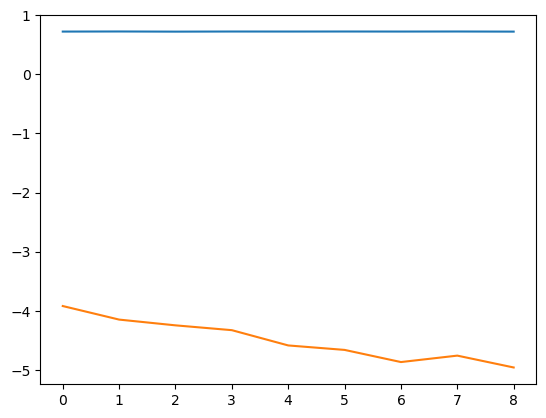

In [26]:
sns.lineplot(coherence_scores)
sns.lineplot(perplexity_scores)
plt.show()